In [76]:
import pandas as pd
import networkx as nx
print(nx.__version__)
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from utils import *
from plot_utils import *
from metrics import *

import warnings
warnings.filterwarnings('ignore')

init_notebook_mode(connected=True)

2.5


# Load Dataset

In [2]:
data_download()

Download completed


In [ ]:
#specifica country, base è italy
match_id2match, match_id2events, player_id2player, competition_id2competition, team_id2team = load_public_dataset(data_folder=data_folder, tournament = 'Italy')

In [3]:
#Genera dataset di soli eventi selezionati

def isolate_event(country, label):
    match_id2match, match_id2events, player_id2player, competition_id2competition, team_id2team = load_public_dataset(data_folder=data_folder, tournament = country)
    df = pd.read_json("data/events/events_{}.json".format(country))
    matchlist = df['matchId'].unique()
    label_list=[]
    if label == 'goal':
        event_tag = 101
    elif label == 'assist':
        event_tag = 301
    elif label == 'keypass':
        event_tag =302
    else:
        raise Exception("no tag for this event")

    for i in matchlist:
        match_events = match_id2events[i]
        for x in match_id2events.items():
            for event in match_events:
                tags = event['tags']
                for tag in tags:
                    if tag['id'] == event_tag:
                        label_list.append([event['eventId'], 
                                event['subEventName'], 
                                event['positions'],
                                event['matchId'],
                                event['eventName'],
                                event['teamId'],
                                event['matchPeriod'], 
                                event['eventSec'],
                                event['subEventId'], 
                                event['id']
                                ])
    label_df= pd.DataFrame(label_list, columns=['eventId','subEventName','positions', 'matchId', 'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id'])
    label_df['x_start'] = [x[0]['x'] for x in label_df['positions']]
    label_df['y_start'] = [x[0]['y'] for x in label_df['positions']]
    label_df= label_df.drop_duplicates(subset=['id', 'eventName'], keep='first')
    label_df = label_df[label_df['x_start'] != 100]
    label_df = label_df[label_df['x_start'] != 0]
    label_df = label_df[label_df['subEventName'] != 'Penalty']
    label_df = label_df[label_df['subEventName'] != 'Corner']
    return label_df

#### Single Match 

In [4]:
match_id = 2576335 # a single match in Italy
match_events = match_id2events[match_id]
match_label = match_id2match[match_id]['label']
            
match_df = pd.DataFrame(match_events)
match_df.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],3344,"[{'y': 50, 'x': 49}, {'y': 58, 'x': 38}]",2576335,Pass,3161,1H,2.417590,85,253668302
1,8,Simple pass,[{'id': 1801}],116349,"[{'y': 58, 'x': 38}, {'y': 91, 'x': 37}]",2576335,Pass,3161,1H,3.904412,85,253668303
2,8,Simple pass,[{'id': 1801}],135903,"[{'y': 91, 'x': 37}, {'y': 72, 'x': 34}]",2576335,Pass,3161,1H,6.484211,85,253668304
3,8,Simple pass,[{'id': 1801}],138408,"[{'y': 72, 'x': 34}, {'y': 14, 'x': 36}]",2576335,Pass,3161,1H,10.043835,85,253668306
4,8,Simple pass,[{'id': 1801}],21094,"[{'y': 14, 'x': 36}, {'y': 39, 'x': 30}]",2576335,Pass,3161,1H,14.032070,85,253668308


In [5]:
#minutaggio
match_df['time'] = np.where(match_df['matchPeriod']=='2H',match_df['eventSec'].map(lambda x: round((x/60)+46)),match_df['eventSec'].map(lambda x: round(x/60+1)))

In [6]:
match_df['x_start'] = [x[0]['x'] for x in match_df['positions']]
match_df['y_start'] = [x[0]['y'] for x in match_df['positions']]
match_df.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,time,x_start,y_start
0,8,Simple pass,[{'id': 1801}],3344,"[{'y': 50, 'x': 49}, {'y': 58, 'x': 38}]",2576335,Pass,3161,1H,2.417590,85,253668302,1,49,50
1,8,Simple pass,[{'id': 1801}],116349,"[{'y': 58, 'x': 38}, {'y': 91, 'x': 37}]",2576335,Pass,3161,1H,3.904412,85,253668303,1,38,58
2,8,Simple pass,[{'id': 1801}],135903,"[{'y': 91, 'x': 37}, {'y': 72, 'x': 34}]",2576335,Pass,3161,1H,6.484211,85,253668304,1,37,91
3,8,Simple pass,[{'id': 1801}],138408,"[{'y': 72, 'x': 34}, {'y': 14, 'x': 36}]",2576335,Pass,3161,1H,10.043835,85,253668306,1,34,72
4,8,Simple pass,[{'id': 1801}],21094,"[{'y': 14, 'x': 36}, {'y': 39, 'x': 30}]",2576335,Pass,3161,1H,14.032070,85,253668308,1,36,14


In [7]:
#DA DOVE ARRIVA IL PASSAGGIO?
pass_df = match_df[match_df['eventName'] == 'Pass'] #single match

In [8]:
pass_df['x_start'] = [x[0]['x'] for x in pass_df['positions']]
pass_df['y_start'] = [x[0]['y'] for x in pass_df['positions']]
pass_df['x_end'] = [x[1]['x'] for x in pass_df['positions']]
pass_df['y_end'] = [x[1]['y'] for x in pass_df['positions']]

In [9]:
#PASSAGGI DIAGONALI IN AVANTI
diagonal_pass = pass_df[pass_df['x_start'] != pass_df['x_end']]
diagonal_pass = diagonal_pass[diagonal_pass['y_start'] != diagonal_pass['y_end']]
diagonal_pass = diagonal_pass[diagonal_pass['x_start'] < diagonal_pass['x_end']]

In [129]:
diagonal_pass.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,time,x_start,y_start,x_end,y_end
3,8,Simple pass,[{'id': 1801}],138408,"[{'y': 72, 'x': 34}, {'y': 14, 'x': 36}]",2576335,Pass,3161,1H,10.043835,85,253668306,1,34,72,36,14
6,8,Simple pass,[{'id': 1801}],138408,"[{'y': 55, 'x': 21}, {'y': 9, 'x': 30}]",2576335,Pass,3161,1H,20.915884,85,253668311,1,21,55,30,9
7,8,Simple pass,[{'id': 1801}],21094,"[{'y': 9, 'x': 30}, {'y': 10, 'x': 46}]",2576335,Pass,3161,1H,24.813096,85,253668313,1,30,9,46,10
8,8,Simple pass,[{'id': 1801}],14812,"[{'y': 10, 'x': 46}, {'y': 22, 'x': 47}]",2576335,Pass,3161,1H,26.521655,85,253668314,1,46,10,47,22
9,8,Simple pass,[{'id': 1801}],69968,"[{'y': 22, 'x': 47}, {'y': 32, 'x': 48}]",2576335,Pass,3161,1H,28.036455,85,253668315,1,47,22,48,32


### Italy goal, assist, keypasses

In [8]:
goal_italy = isolate_event('Italy', 'goal')

In [ ]:
assist_italy = isolate_event('Italy', 'assist')

In [ ]:
keypass_italy = isolate_event('Italy', 'keypass')

### Spain goal, assist, keypasses

In [ ]:
goal_spain = isolate_event('Spain', 'goal')

In [5]:
assist_spain = isolate_event('Spain', 'assist')

In [6]:
keypass_spain = isolate_event('Spain', 'keypass')

### Germany goal, assist, keypasses

In [12]:
goal_deu = isolate_event('Germany', 'goal')

In [13]:
assist_deu = isolate_event('Germany', 'assist')

In [14]:
keypass_deu = isolate_event('Germany', 'keypass')

### England goal, assist, keypasses

In [3]:
goal_eng = isolate_event('England', 'goal')

In [4]:
assist_eng = isolate_event('England', 'assist')

In [29]:
keypass_eng = isolate_event('England', 'keypass')

## Plots

### Six-by-Three 
Coaches like Louis van Gaal prefer to divide the field into a six-by-three grid, so that there are 18 zones on the (practice) pitch. The central strip is usually a bit wider, while the three vertical strips are divided into a middle strip and two flanks. According to the version of possession play, certain zones and positions require certain duties players have to fulfil. This kind of divide of the pitch is purely geometric.

-spielverlagerung

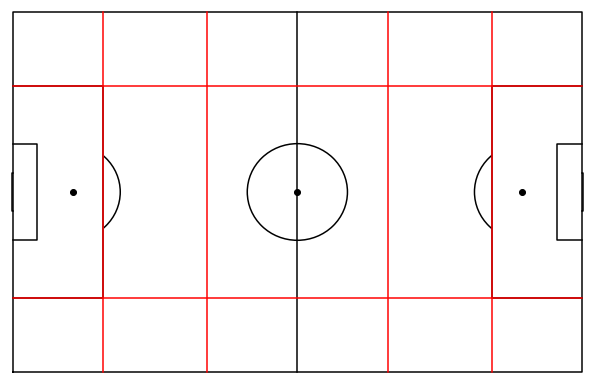

In [9]:
draw_pitch_grid("white", "black", "h", "full")

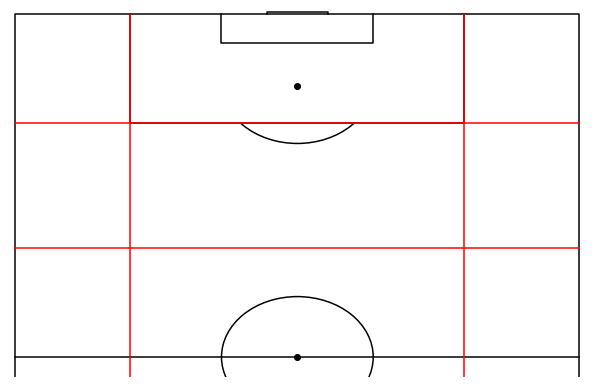

In [10]:
f = draw_pitch_grid("white", "black", "v", "half")

### Zone 14

On a pitch divided into a six-by-three grid with a central strip as wide as the six yard box, the Zone 14, also called The Hole, has been classified as the rectangle which helps teams score more goals. Zone 14 is the zone located in the middle of the pitch immediately outside the opposing penalty area. During the 1990s and early 2000s, statistical data showed that successful teams such as the World Cup winning team of France or 1999 Champions League winner Manchester United had a better performance in Zone 14, as it was the key area which produced vast majority of passing assist. Until today, some prefer the concept of using Zone 14 as a target area in terms of build-up play, mostly denying the use of cross passes. According to various studies, the most effective way to use Zone 14 is to play a pass into the penalty area. Plus, the phase of possession in Zone 14 should not take longer than eight seconds.

-spielverlagerung

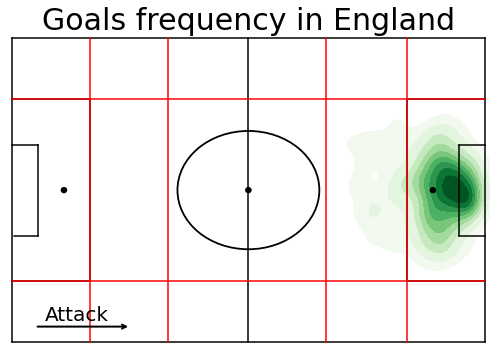

In [32]:
#GOAL
fig, ax = pitch_grid()
sns.kdeplot(goal_eng['x_start'], goal_eng['y_start'], cmap = 'Greens', shade = True)
        
plt.title('Goals frequency in England', fontsize = 30)
plt.xlim(-1,101)
plt.ylim(-1,101)
plt.axis('off')
fig.tight_layout()
plt.show()

In [38]:
goal_zone14 = goal_eng[goal_eng['y_start'].between(13.84,54.16)]
goal_zone14 = goal_zone14[goal_zone14['x_start'].between(68.5,87.5)]

print('percentuale goal segnati da zone 14: {}%'.format(round(len(goal_zone14)/len(goal_eng)*100, 2)))

percentuale goal segnati da zone 14: 16.43%


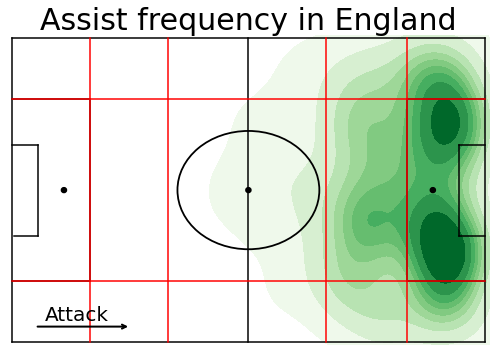

In [34]:
#ASSIST
fig, ax = pitch_grid()
sns.kdeplot(assist_eng['x_start'], assist_eng['y_start'], cmap = 'Greens', shade = True)
        
plt.title('Assist frequency in England', fontsize = 30)
plt.xlim(-1,101)
plt.ylim(-1,101)
plt.axis('off')
fig.tight_layout()
plt.show()

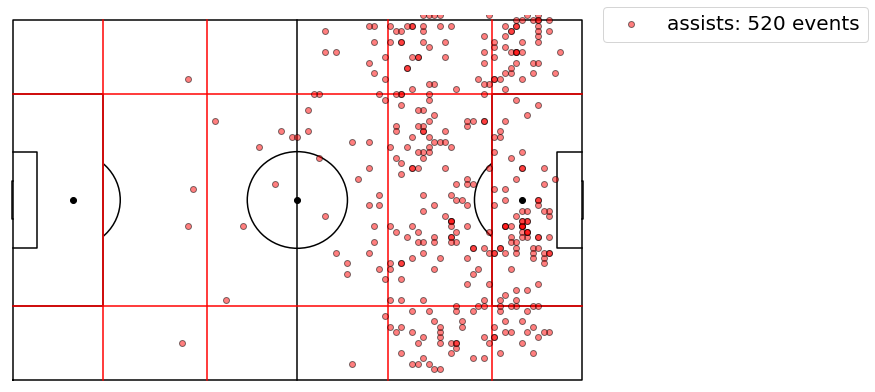

In [26]:
#team_1, team_2 = np.unique(goal_df['teamId'])
df_team_1 = assist_df
#df_team_2 = goal_df[goal_df['teamId'] == team_2]

f = draw_pitch_grid("white", "black", "h", "full")
plt.scatter(df_team_1['x_start'], df_team_1['y_start'], c='red', edgecolors="k", zorder=12, 
            alpha=0.5, label='%s: %s events' %('assists', len(df_team_1)))
#plt.scatter(df_team_2['x_start'], df_team_2['y_start'], marker='s', c='blue', edgecolors="w", linewidth=0.25, zorder=12, 
            #alpha=0.7, label='%s: %s events' %(team_id2team[team_2]['name'], len(df_team_2)))
plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1.05))
#plt.title(match_label, fontsize=20)
plt.show()

In [35]:
assist_zone14 = assist_eng[assist_eng['y_start'].between(13.84,54.16)]
assist_zone14 = assist_zone14[assist_zone14['x_start'].between(68.5,87.5)]

print('percentuale assist da golden zone: {}%'.format(round(len(assist_zone14)/len(assist_eng)*100, 2)))

percentuale assist da golden zone: 19.01%


In [41]:
def plot_kde_events_on_field(sample_size=10000):
    """
    Generate density plots on the field for each event type
    
    Parameters
    ----------
    sample_size: int
        random sample of values to use (default: 10000). The code becomes slow is you increase this value
        significantly.
    """
    positions = []
    for match_events in match_id2events.values():
        for event in match_events:
            positions.append([event['eventName'], 
                              event['positions'][0]['x'], 
                              event['positions'][0]['y']])

    positions_df = pd.DataFrame(positions, columns=['eventName','x','y'])

    for event_type in EVENT_TYPES:
        pos_event_df = positions_df[positions_df['eventName'] == event_type]
        fig, ax = pitch_grid()
        if len(pos_event_df) >= sample_size:
            x_y = pos_event_df[['x','y']].sample(sample_size).astype(float)
        else:
            x_y = pos_event_df[['x','y']].astype(float)
        
        sns.kdeplot(x_y['x'], x_y['y'], cmap = 'Greens', shade = True)
        
        plt.title(event_type, fontsize = 30)
        plt.xlim(-1,101)
        plt.ylim(-1,101)
        plt.axis('off')
        fig.tight_layout()
        plt.show()

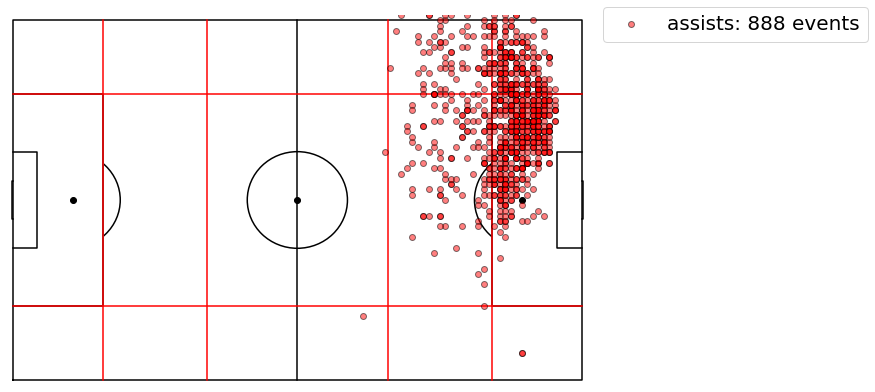

In [11]:
df_team_1 = goal_italy

f = draw_pitch_grid("white", "black", "h", "full")
plt.scatter(df_team_1['x_start'], df_team_1['y_start'], c='red', edgecolors="k", zorder=12, 
            alpha=0.5, label='%s: %s events' %('assists', len(df_team_1)))
plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1.05))
#plt.title(match_label, fontsize=20)
plt.show()

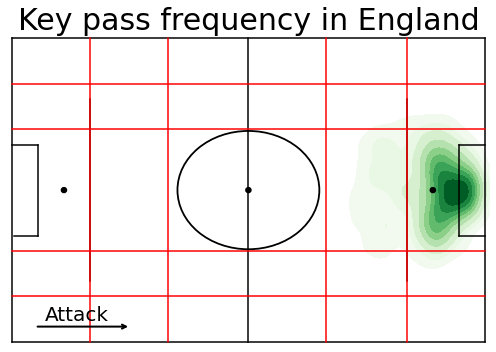

In [77]:
#KEYPASS
fig, ax = pitch_graph_zone()
sns.kdeplot(goal_italy['x_start'], goal_italy['y_start'], cmap = 'Greens', shade = True)
        
plt.title('Key pass frequency in England', fontsize = 30)
plt.xlim(-1,101)
plt.ylim(-1,101)
plt.axis('off')
fig.tight_layout()
plt.show()

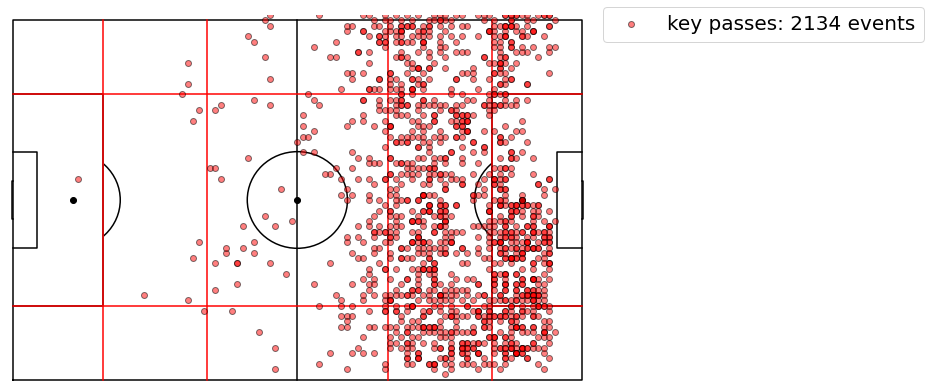

In [112]:
df_team_1 = keypass_df

f = draw_pitch_grid("white", "black", "h", "full")
plt.scatter(df_team_1['x_start'], df_team_1['y_start'], c='red', edgecolors="k", zorder=12, 
            alpha=0.5, label='%s: %s events' %('key passes', len(df_team_1)))
plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1.05))
plt.show()

In [40]:
keypass_zone14 = keypass_eng[keypass_eng['y_start'].between(13.84,54.16)]
keypass_zone14 = keypass_zone14[keypass_zone14['x_start'].between(68.5,87.5)]

print('percentuale key pass da golden zone: {}%'.format(round(len(keypass_zone14)/len(keypass_spain)*100, 2)))

percentuale key pass da golden zone: 16.44%


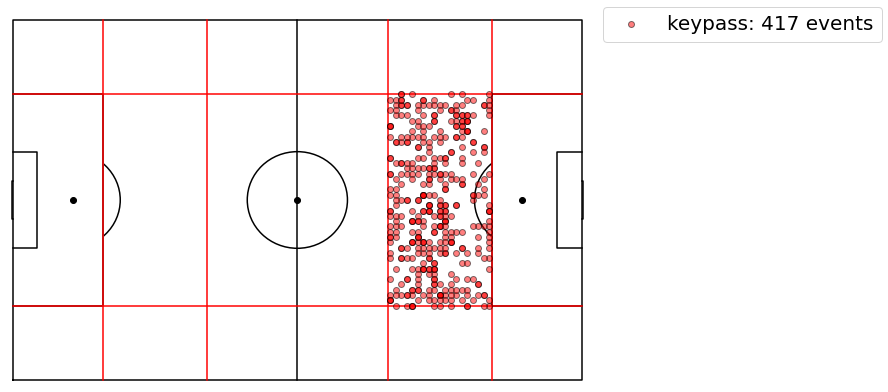

In [115]:
df_team_1 = keypass_zone14

f = draw_pitch_grid("white", "black", "h", "full")
plt.scatter(df_team_1['x_start'], df_team_1['y_start'], c='red', edgecolors="k", zorder=12, 
            alpha=0.5, label='%s: %s events' %('keypass', len(df_team_1)))
plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1.05))
#plt.title(match_label, fontsize=20)
plt.show()

la zone 14 non sembra così interessata per quanto riguarda gol e assist, l'area di rigore e le fasce hanno un'influenza maggiore, posso continuare l'analisi con gli eventi PASS e SHOTS

### Half-Space
In contrast to solely geometrical zoning of a pitch, one can also divide the field into certain zones, while taking tactical aspects into consideration. Particularly, half-spaces, the vertical strips between centre and wings, have played a crucial role in the recent past. Among other things, the half-space exists for the purposes of an analytical approach. Looking at the movements of the two teams, you do not only recognize different positioning, when the ball is on the wing or in the centre, but also when it is in between – in the half-space.

By adding the half-spaces, the strategical facets of a pitch change. When ball carriers are in the half-space, they have as many options as a ball carrier in the middle, but can cause more diagonal passing and movement patterns towards the outside or the middle, while their goal-orientated fields of vision do not change. In contrast, ball carriers in the middle have to avert their gaze at the opposing goal when intending to play to the outside.

By the way, while half-spaces seem to be just static zones, they could also continually change during a match. This is the concept of an effective field, in which the half-spaces as well as other zones vary consistently, and become situation-dependent, dynamic half-spaces.

-spielverlagerung

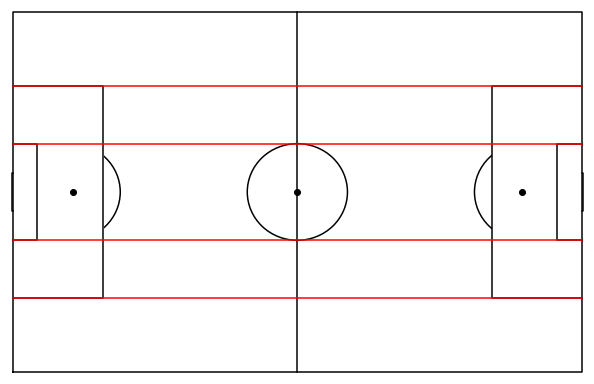

In [45]:
draw_pitch_halfspace("white", "black", "h", "full")

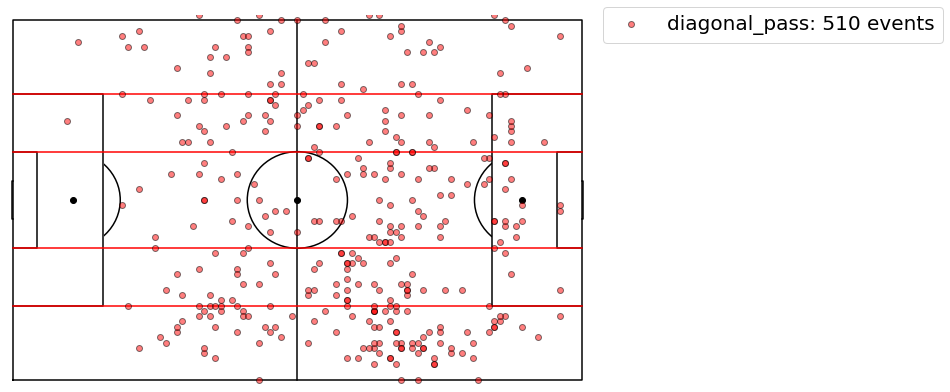

In [130]:
df_team_1 = diagonal_pass


f = draw_pitch_halfspace("white", "black", "h", "full")
plt.scatter(df_team_1['x_end'], df_team_1['y_end'], c='red', edgecolors="k", zorder=12, 
            alpha=0.5, label='%s: %s events' %('diagonal_pass', len(df_team_1)))
plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1.05))
plt.show()

In [131]:
diagonal_hs_1 = diagonal_pass[diagonal_pass['y_end'].between(43.16,54.16)]
diagonal_hs_2 = diagonal_pass[diagonal_pass['y_end'].between(13.84,24.84)]
diagonal_hs = pd.concat([diagonal_zone14_1, diagonal_zone14_2])

print('percentuale diagonal pass negli half space: {}%'.format(round(len(diagonal_hs)/len(diagonal_pass)*100, 2)))

percentuale diagonal pass negli half space: 40.0%


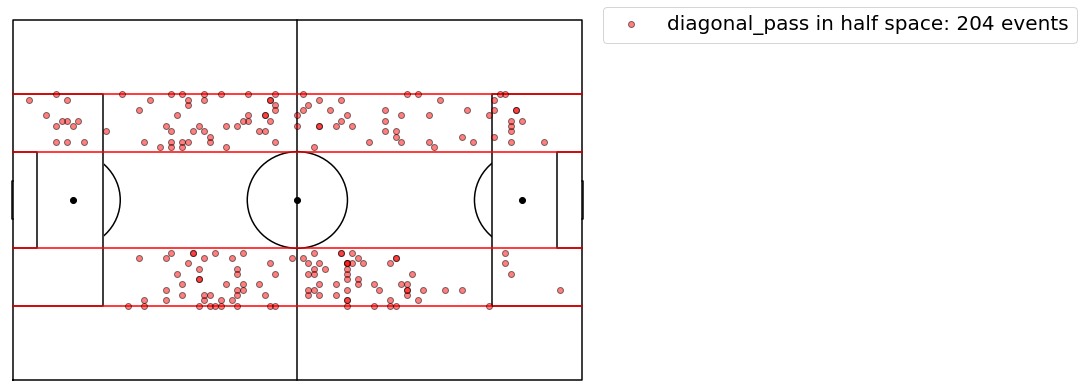

In [132]:
df_team_1 = diagonal_hs

f = draw_pitch_halfspace("white", "black", "h", "full")
plt.scatter(df_team_1['x_end'], df_team_1['y_end'], c='red', edgecolors="k", zorder=12, 
            alpha=0.5, label='%s: %s events' %('diagonal_pass in half space', len(df_team_1)))
plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1.05))
plt.show()

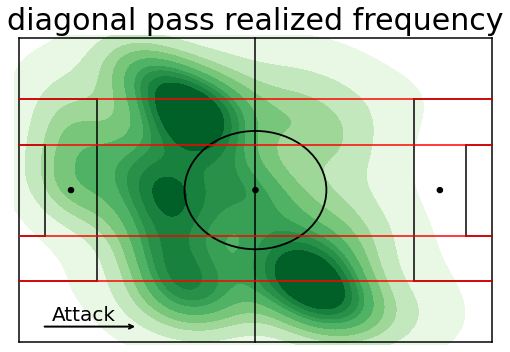

In [133]:
#PASSING FREQUENCY EFFETTUATI
fig, ax = pitch_halfspace()
sns.kdeplot(diagonal_pass['x_start'], diagonal_pass['y_start'], cmap = 'Greens', shade = True)
        
plt.title('diagonal pass realized frequency', fontsize = 30)
plt.xlim(-1,101)
plt.ylim(-1,101)
plt.axis('off')
fig.tight_layout()
plt.show()

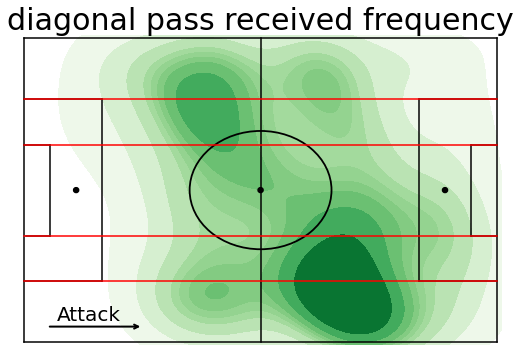

In [134]:
#PASSING FREQUENCY RECEIVED
fig, ax = pitch_halfspace()
sns.kdeplot(diagonal_pass['x_end'], diagonal_pass['y_end'], cmap = 'Greens', shade = True)
        
plt.title('diagonal pass received frequency', fontsize = 30)
plt.xlim(-1,101)
plt.ylim(-1,101)
plt.axis('off')
fig.tight_layout()
plt.show()

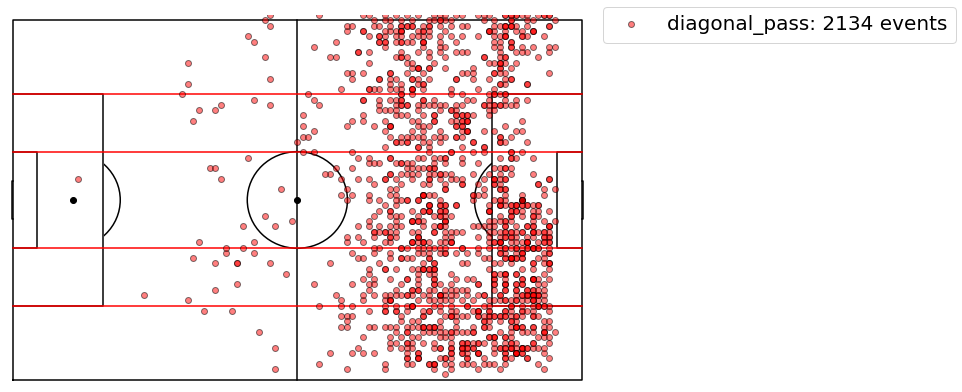

In [135]:
#KEY PASS effettuati
df_team_1 = keypass_df


f = draw_pitch_halfspace("white", "black", "h", "full")
plt.scatter(df_team_1['x_start'], df_team_1['y_start'], c='red', edgecolors="k", zorder=12, 
            alpha=0.5, label='%s: %s events' %('key_pass', len(df_team_1)))
plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1.05))
plt.show()

In [28]:
keypass_hs_1 = keypass_spain[keypass_spain['y_start'].between(43.16,54.16)]
keypass_hs_2 = keypass_spain[keypass_spain['y_start'].between(13.84,24.84)]
keypass_hs = pd.concat([keypass_hs_1, keypass_hs_2])

print('percentuale key passes effettuati negli half space: {}%'.format(round(len(keypass_hs)/len(keypass_spain)*100, 2)))

percentuale key passes effettuati negli half space: 17.98%


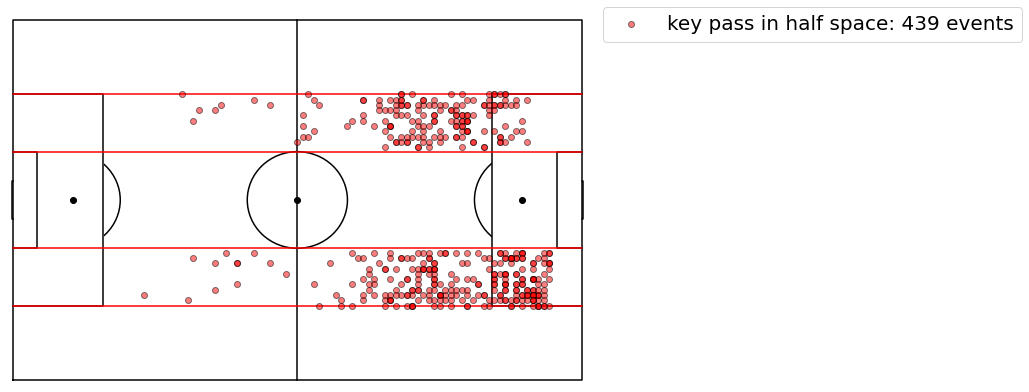

In [123]:
df_team_1 = keypass_hs


f = draw_pitch_halfspace("white", "black", "h", "full")
plt.scatter(df_team_1['x_start'], df_team_1['y_start'], c='red', edgecolors="k", zorder=12, 
            alpha=0.5, label='%s: %s events' %('key pass in half space', len(df_team_1)))
plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1.05))
plt.show()

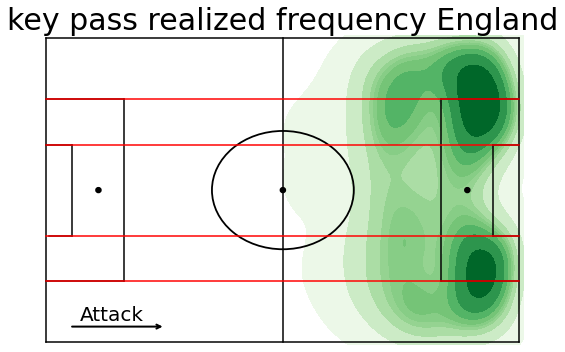

In [36]:
fig, ax = pitch_halfspace()
sns.kdeplot(keypass_eng['x_start'], keypass_eng['y_start'], cmap = 'Greens', shade = True)
        
plt.title('key pass realized frequency England', fontsize = 30)
plt.xlim(-1,101)
plt.ylim(-1,101)
plt.axis('off')
fig.tight_layout()
plt.show()

# Pitch division 6x3 + halfspace

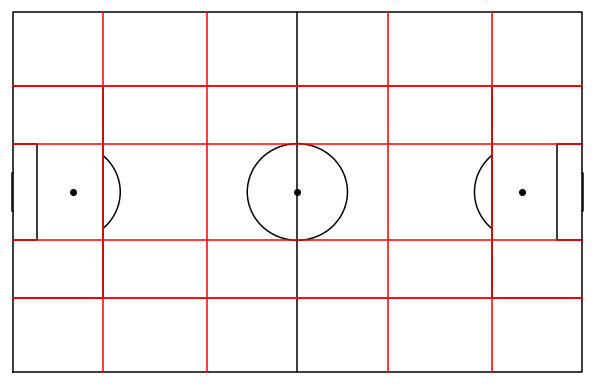

In [4]:
draw_pitch_graph_zone("white", "black", "h", "full")